<a href="https://colab.research.google.com/github/s-c-soma/RL_Project_FlappyBird_D3QN/blob/main/colab/Flappy_DoubleDueling_DQN_GoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Double Dueling Deep Q Network Learning with Priortized Experienced Reply

This colab is used to run the code from our google drive.

#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch
!pip install torchvision
!pip install opencv-python

In [ ]:
import os,sys
import cv2
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
os.chdir('../')

In [3]:
!git clone https://github.com/s-c-soma/RL_Project_FlappyBird_D3QN.git

Cloning into 'RL_Project_FlappyBird_D3QN'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 168 (delta 58), reused 39 (delta 17), pack-reused 67
Receiving objects: 100% (168/168), 86.53 MiB | 23.52 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
!ls

bin	 etc			      lib64  root   sys		       var
boot	 flappy-bird-deep-q-learning  media  run    tensorflow-1.15.2
content  home			      mnt    sbin   tmp
datalab  lib			      opt    srv    tools
dev	 lib32			      proc   swift  usr


In [ ]:
os.chdir('flappy-bird-deep-q-learning')
!ls

 assets			  game		 README.md
 checkpoints		  LICENSE	 requirements.txt
'Deep Q Learning.ipynb'   play_game.py	 screenshots


In [ ]:
#sys.path.append('game/')
os.chdir('game')


In [ ]:
!pip install pygame 

     |████████████████████████████████| 11.5MB 12.0MB/s 


In [ ]:
import pygame
DISPLAY = True
if not DISPLAY:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.0.0 (SDL 2.0.12, python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Alternative Part- To run From Google Drive

In [ ]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))
pygame.init()
pygame.display.init()
print( pygame.display.list_modes() )

[(640, 480)]


In [ ]:
!ls

flappy_utils.py  flappy_wrapped.py


In [ ]:
os.getcwd()
!ls

flappy_utils.py  flappy_wrapped.py


In [ ]:
sys.path.append('game/')

#Loading *flappy_wrapped* from drive

## Change File Paths

Please upload the code in google shared drive and change the paths accordingly

In [ ]:
# the base Google Drive directory
root_dir = "/content/drive/Shared drives/"

# path to save the project files in google drive
project_folder = "MeanSquare-Drive/RL-assignment/flappy-bird-deep-q-learning/"

#folder_path in shared drive
folder_path = '/content/drive/Shared drives/MeanSquare-Drive/RL-assignment/flappy-bird-deep-q-learning'

In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!


root_dir = root_dir


project_folder = project_folder

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/Shared drives/MeanSquare-Drive/RL-assignment/flappy-bird-deep-q-learning/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
import sys
sys.path.append(folder_path)

In [ ]:
os.getcwd()

'/content/drive/Shared drives/MeanSquare-Drive/RL-assignment/flappy-bird-deep-q-learning'

In [ ]:
import flappy_wrapped as game

# KERNEL

In [ ]:
KERNEL = np.array([[-1,-1,-1], [-1, 9,-1],[-1,-1,-1]])
def processFrame(frame):
    frame = frame[55:288,0:400] #crop image
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) #convert image to black and white
    frame = cv2.resize(frame,(84,84),interpolation=cv2.INTER_AREA)
    _ , frame = cv2.threshold(frame,50,255,cv2.THRESH_BINARY)
    #frame = cv2.blur(frame,(5,5))
    frame = cv2.filter2D(frame,-1,KERNEL)
    #frame = cv2.Canny(frame,100,200)
    frame = frame.astype(np.float64)/255.0
    return frame

# Dueling DQN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

#Dueling DQN
class DDQN(nn.Module):
    def __init__(self,input_shape,nactions):
        super(DDQN,self).__init__()
        self.nactions = nactions
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=2,stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        #scs - action network with 'nactions with q value' as output
        self.fca = nn.Sequential(
            nn.Linear( conv_out_size, 512),
            nn.ReLU(),
            nn.Linear( 512, nactions )
        )
        
        #scs - value network with single value output
        self.fcv = nn.Sequential(
            nn.Linear(conv_out_size,512),
            nn.ReLU(),
            nn.Linear(512,1)
        )
        
    def _get_conv_out(self,shape):
        o = self.conv( torch.zeros(1,*shape) )
        return int(np.prod(o.size()))
    
    def forward(self,x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        action_v = self.fca(conv_out)
        value_v = self.fcv(conv_out).expand(x.size(0), self.nactions)
        #scs aggregation layer:  Q(s,a) = V(s) + A(s,a)- mean(A(s,a))
        return value_v + action_v - action_v.mean(1).unsqueeze(1).expand(x.size(0), self.nactions)

# Hyperparam

In [ ]:
ACTIONS = [0,1]
EXPERIENCE_BUFFER_SIZE = 2000 #2000-> update 4000, 20000,500
STATE_DIM = 4
GAMMA = 0.99  #0.99 # -> update
EPSILON_START = 1
EPSILON_FINAL = 0.001
EPSILON_DECAY_FRAMES = (10**4)/3 # -> update
MEAN_GOAL_REWARD = 10 #10 # +1 for escaping death
BATCH_SIZE = 32 #-> update
MIN_EXP_BUFFER_SIZE = 500 #
SYNC_TARGET_FRAMES = 30 #15,60, 90tau ,go in times of 30 or 30/2 value- change this value for differeny sync time with target_net
LEARNING_RATE = 1e-4 #-> update
SKIP_FRAME = 2 #->update
INITIAL_SKIP = [0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1]

# Prioritized Experience Buffer

In [ ]:
import collections
class ExperienceBuffer():
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity)
        self.priority = collections.deque(maxlen=capacity)
    
    def clear(self):
        self.buffer.clear()
        self.priority.clear()
        
    def __len__(self):
        return len(self.buffer)
    
    def append(self,exp,p):
        self.buffer.append(exp)
        self.priority.append(p)
        
    def sample(self,batch_size):
        #scs- probability or priority computation
        probs = np.array(self.priority)/sum(np.array(self.priority))
        indices = np.random.choice( range(len(self.buffer)), batch_size, p = probs)
        states,actions,rewards,dones,next_states = zip(*[ self.buffer[idx] for idx in indices ])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),\
    np.array(dones,dtype=np.uint8), np.array(next_states)

# Agent

In [ ]:
class Agent():
    def __init__(self,env,buffer,state_buffer_size = STATE_DIM):
        self.env = env
        self.exp_buffer = buffer
        self.state = collections.deque(maxlen = STATE_DIM)
        self.next_state= collections.deque(maxlen = STATE_DIM)
        self._reset()
        
    def _reset(self):
        self.total_rewards = 0
        self.state.clear()
        self.next_state.clear()
        
        for i in INITIAL_SKIP[:-7]:
            frame,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(frame)
        self.state.append(frame)
        self.next_state.append(frame)

        for i in INITIAL_SKIP[-7:-5]:
            frame,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(frame)
        self.state.append(frame)
        self.next_state.append(frame)
        
        for i in INITIAL_SKIP[-5:-3]:
            frame,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(frame)
        self.state.append(frame)
        self.next_state.append(frame)
        
        for i in INITIAL_SKIP[-3:-1]:
            frame,reward,done = self.env.frame_step(i)
            self.total_rewards+=reward
            if done:
                self._reset()
        frame = processFrame(frame)
        self.state.append(frame)
        self.next_state.append(frame)
    
    def step(self,net,tgt_net,epsilon=0.9,device='cpu'):
        self.total_rewards = 0
        if np.random.random() < epsilon:
            #scs random exploration
            action = np.random.choice(ACTIONS)
        else:
            #scs taking state and action
            state_v = torch.tensor(np.array([self.state],copy=False),dtype=torch.float32).to(device)
            action = int(torch.argmax(net(state_v)))
       
        frame,reward,done = self.env.frame_step(action)
        self.total_rewards += reward
        for _ in range(SKIP_FRAME):
                frame,reward,done =  self.env.frame_step(action)
                self.total_rewards += reward
                if done:
                    break
                    
        frame = processFrame(frame)
        self.next_state.append(frame)
        
        if len(self.next_state)==STATE_DIM and len(self.state)==STATE_DIM:
            #scs PER - Prioritized Experience Replay
            o = net( torch.tensor( np.array([self.state]),dtype=torch.float32).to(device)).to('cpu').detach().numpy()[0][action]
            e = float(torch.max(tgt_net( torch.tensor( np.array([self.next_state]),dtype=torch.float32).to(device))))
            #scs priority
            p = abs(o-e)+0.0001
            #print("priority ", p)
            #scs (exp = state, action, reward, state_next), priority: storing value to the PER
            self.exp_buffer.append((self.state.copy(),action,int(self.total_rewards),done,self.next_state.copy()),p)
        
        self.state.append(frame)
        
        end_reward = int(self.total_rewards)
        if done:
            self._reset()
        
        return end_reward

# Loss

In [ ]:
def calc_loss(batch,net,tgt_net,device='cpu'):
    states,actions,rewards,dones,next_states = batch
    
    states_v = torch.tensor(states,dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions,dtype=torch.long).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    dones_v = torch.ByteTensor(dones).to(device)
    next_states_v = torch.tensor(next_states,dtype=torch.float32).to(device)
    
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1) # Q(S,A) = V + A
    next_state_action_values = tgt_net(next_states_v).max(1)[0] # max(Q(A))
    next_state_action_values[dones_v] = 0.0
    next_state_action_values = next_state_action_values.detach() 
    
    expected_values = rewards_v +  next_state_action_values * GAMMA # scs rewards + max(Q(A)) * discount_factor
    return nn.MSELoss()(state_action_values,expected_values)   #loss computation: Target- Computed

# Training

In [ ]:
all_losses = []
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

#Double Dueling DQN
#scs primary network
net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)
#print("net: ", net)

#target network
tgt_net = DDQN( (STATE_DIM,84,84), len(ACTIONS) ).to(device)
#print("tgt_net: ",tgt_net)

env = game.GameState()
#print("env: ",env)
buffer = ExperienceBuffer(EXPERIENCE_BUFFER_SIZE)
#print("buffer: ",buffer)
agent = Agent(env,buffer)
#print("agent: ",agent)
epsilon = EPSILON_START
#print("epsilon: ",epsilon)
optimizer = optim.Adam(net.parameters(),lr=LEARNING_RATE)
#print("optimizer: ",optimizer)

# initializing
total_rewards = []
best_mean_reward = float('-inf')
last_mean = float('-inf')
game_id = 0

while True:
    epsilon = max( EPSILON_FINAL , EPSILON_START - game_id/EPSILON_DECAY_FRAMES )
    #print("inside loop, epsilon",epsilon)
    reward = agent.step(net,tgt_net,epsilon,device=device)
    #print("reward: ",reward)
    if reward != 0:
        game_id += 1
        total_rewards.append(reward)
        mean_reward = np.mean(total_rewards[-100:]) # 100
        #print("mean_reward: ",mean_reward)

        if game_id%5 == 0:  #print after every 5 iteration
            print("GAME : {} | EPSILON : {:.4f} | MEAN REWARD : {}".format( game_id, epsilon, mean_reward ))
            #print("##############################################################")
        if best_mean_reward < mean_reward:
            best_mean_reward = mean_reward
            #print("best_mean_reward ", best_mean_reward)
            #print("last_mean: ", last_mean)
            if best_mean_reward - last_mean >= 0.1:
                torch.save(net.state_dict(),'model/flappy_best_model.dat')
                print("REWARD {} -> {}. Model Saved".format(last_mean,mean_reward))
                last_mean = best_mean_reward

        if game_id % SYNC_TARGET_FRAMES == 0:         #update after Tau step
            tgt_net.load_state_dict(net.state_dict()) # step of duelling, using net DDQN weights to load target DDQN
            
        if mean_reward >= MEAN_GOAL_REWARD:
            print("Learned in {} Games.".format(game_id))
            break
    
    if len(buffer) < MIN_EXP_BUFFER_SIZE:
        continue
    
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    #print("batch: ", batch)
    loss_t = calc_loss(batch,net,tgt_net,device=device)
    #print("loss_t: ", float(loss_t))
    all_losses.append(float(loss_t))
    loss_t.backward()
    optimizer.step()

REWARD -inf -> -1.0. Model Saved
GAME : 5 | EPSILON : 0.9988 | MEAN REWARD : -1.0
GAME : 10 | EPSILON : 0.9973 | MEAN REWARD : -1.0
GAME : 15 | EPSILON : 0.9958 | MEAN REWARD : -1.0
GAME : 20 | EPSILON : 0.9943 | MEAN REWARD : -1.0
GAME : 25 | EPSILON : 0.9928 | MEAN REWARD : -1.0
GAME : 30 | EPSILON : 0.9913 | MEAN REWARD : -1.0
GAME : 35 | EPSILON : 0.9898 | MEAN REWARD : -0.9428571428571428
GAME : 40 | EPSILON : 0.9883 | MEAN REWARD : -0.95
GAME : 45 | EPSILON : 0.9868 | MEAN REWARD : -0.9555555555555556
GAME : 50 | EPSILON : 0.9853 | MEAN REWARD : -0.96
GAME : 55 | EPSILON : 0.9838 | MEAN REWARD : -0.9272727272727272
GAME : 60 | EPSILON : 0.9823 | MEAN REWARD : -0.9333333333333333
GAME : 65 | EPSILON : 0.9808 | MEAN REWARD : -0.9384615384615385


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  if sys.path[0] == '':


GAME : 70 | EPSILON : 0.9793 | MEAN REWARD : -0.9428571428571428
GAME : 75 | EPSILON : 0.9778 | MEAN REWARD : -0.9466666666666667
GAME : 80 | EPSILON : 0.9763 | MEAN REWARD : -0.925
GAME : 85 | EPSILON : 0.9748 | MEAN REWARD : -0.9058823529411765
GAME : 90 | EPSILON : 0.9733 | MEAN REWARD : -0.9111111111111111
REWARD -1.0 -> -0.8901098901098901. Model Saved
GAME : 95 | EPSILON : 0.9718 | MEAN REWARD : -0.8947368421052632
GAME : 100 | EPSILON : 0.9703 | MEAN REWARD : -0.9
GAME : 105 | EPSILON : 0.9688 | MEAN REWARD : -0.9
GAME : 110 | EPSILON : 0.9673 | MEAN REWARD : -0.88
GAME : 115 | EPSILON : 0.9658 | MEAN REWARD : -0.88
GAME : 120 | EPSILON : 0.9643 | MEAN REWARD : -0.88
GAME : 125 | EPSILON : 0.9628 | MEAN REWARD : -0.86
GAME : 130 | EPSILON : 0.9613 | MEAN REWARD : -0.84
GAME : 135 | EPSILON : 0.9598 | MEAN REWARD : -0.86
GAME : 140 | EPSILON : 0.9583 | MEAN REWARD : -0.84
GAME : 145 | EPSILON : 0.9568 | MEAN REWARD : -0.84
GAME : 150 | EPSILON : 0.9553 | MEAN REWARD : -0.84
GAME 

KeyboardInterrupt: ignored

# Plot on Result

In [ ]:
mean_rewards2 = []
#'https://github.com/s-c-soma/RL_Project_FlappyBird_D3QN/blob/main/result_csv/d3qn_mean%20reward.csv'
file_path=  '/content/drive/Shared drives/MeanSquare-Drive/RL-Project/csvfile/d3qn.csv'
with open(file_path,'r') as f:
   #print(f.readlines())
   for x in f.readlines():
        #print(x)
        if x != '\n':
            mean_rewards2.append(float(x.replace('\n','')))
print(len(mean_rewards2))

## Draw Plot

In [ ]:
import matplotlib.pyplot as plt

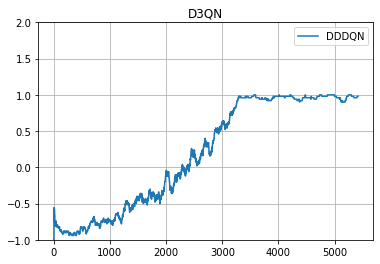

In [ ]:
plt.title("D3QN")
plt.plot(mean_rewards2, label='DDDQN')
#plt.plot(moving_average(rewards_ql), label='qlearning')
plt.grid()
plt.legend()
plt.ylim(-1, 2)
plt.show()

# Run Model

In [ ]:
import play_game

In [ ]:
os.getcwd()

In [ ]:
!ls

In [ ]:
#!python 'play_game.py' --model 'checkpoints/flappy_best_model_game.dat'

# References

* https://www.fromkk.com/posts/using-ddqn-to-play-flappy-bird/​

* https://towardsdatascience.com/use-reinforcement-learning-to-train-a-flappy-bird-never-to-die-35b9625aaecc​

* https://towardsdatascience.com/practical-reinforcement-learning-02-getting-started-with-q-learning-582f63e4acd9​

* http://cs229.stanford.edu/proj2015/362_report.pdf​

* https://github.com/adityajn105

* https://www.freecodecamp.org/news/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8/​

* https://www.freecodecamp.org/news/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682/​

* https://markelsanz14.medium.com/introduction-to-reinforcement-learning-part-4-double-dqn-and-dueling-dqn-b349c9a61ea1​

* https://arxiv.org/pdf/1511.06581.pdf​

* https://arxiv.org/abs/1509.06461